<p>
<img src="../imgs/EII-ULPGC-logo.jpeg" width="430px" align="right">

# **Práctica 2: Autoencoders**
---

Un autoencoder es un tipo de red neuronal utilizada principalmente para tareas de compresión de datos y reducción de dimensionalidad. Su arquitectura consta de dos partes principales:

1. **Codificador (Encoder):** Comprime los datos de entrada en una representación de menor dimensión, conocida como el espacio latente o embebido.

2. **Decodificador (Decoder):** Reconstruye los datos originales a partir de esta representación comprimida.

El objetivo principal de un autoencoder es minimizar la diferencia entre los datos de entrada y los datos reconstruidos

### **Tareas**

Nuestro cometido será utilizar un autoenconder para realizar dos tareas diferentes, un sistema de eliminación de ruido y un generador de imágenes de superresolución.

#### **Eliminación de ruido**

Haremos uso del código del autoencoder suministado en clase y añadiremos un ruido gaussiano a las imágenes de entrada. Las imágenes de salida las compararemos con las imágenes originales.

#### **Superresolución**

Para esa parte deberermos modificar la arquitectura del autoencoder para que admita imágenes de 7x7 y de 14x14 pixels y genere imágenes de 28x28. El objetivo es aumentar artificialmente la resolución de las imágenes

### **Entregables**

Se debe mostrar visualmente los resultados de ambos *autoencoders*, donde se aprecie correctamente tanto la supresión del ruido como la generación de imágenes de superresolución de aspecto cercano a las imágenes originales. Para ello, en ambos *autoencoders* mostraremos como resultado una matriz de imágenes de tres filas y varias columnas. La primera fila contendrá las imágenes reales, la segunda las imágenes con ruido o reducidas en tamaño y la tercera fila contendrá las imágenes generadas por el *autoencoder*.
Se entregará además todo el código usado.

### **Código base**

Haz uso del siguiente código base para implementar los dos *autoencoders*.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))
    ])

transform = transforms.ToTensor()

mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

data_loader = torch.utils.data.DataLoader(dataset=mnist_data,
                                          batch_size=64,
                                          shuffle=True)

mnist_data_valid = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

data_loader_valid = torch.utils.data.DataLoader(dataset=mnist_data_valid,
                                          batch_size=64,
                                          shuffle=True)                        

In [13]:
dataiter = iter(data_loader)
images, labels = next(dataiter)
print(torch.min(images), torch.max(images))

tensor(0.) tensor(1.)


In [4]:
# repeatedly reduce the size
class Autoencoder_Linear(nn.Module):
    def __init__(self):
        super().__init__()        
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128), # (N, 784) -> (N, 128)
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3) # -> N, 3
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
# Input [-1, +1] -> use nn.Tanh

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()        
        # N, 1, 28, 28
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), # -> N, 16, 14, 14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.Conv2d(32, 64, 7) # -> N, 64, 1, 1
        )
        
        # N , 64, 1, 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # N, 16, 14, 14 (N,16,13,13 without output_padding)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # N, 1, 28, 28  (N,1,27,27)
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
# model = Autoencoder()  # Usa este para autoencoder convolutivo para la práctica
model = Autoencoder_Linear()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3, 
                             weight_decay=1e-5)

In [7]:
# Point to training loop video
num_epochs = 10
outputs = []
for epoch in range(num_epochs):
    for (img, _) in data_loader:
        img = img.reshape(-1, 28*28) # -> use for Autoencoder_Linear
        recon = model(img)
        loss = criterion(recon, img)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img, recon))

Epoch:1, Loss:0.0416
Epoch:2, Loss:0.0379
Epoch:3, Loss:0.0426
Epoch:4, Loss:0.0379
Epoch:5, Loss:0.0414
Epoch:6, Loss:0.0343
Epoch:7, Loss:0.0359
Epoch:8, Loss:0.0383
Epoch:9, Loss:0.0299
Epoch:10, Loss:0.0374


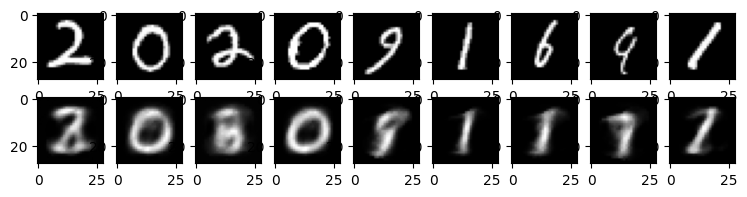

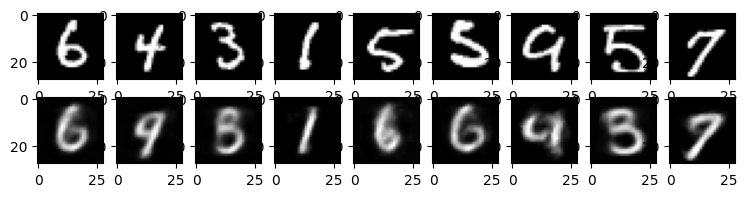

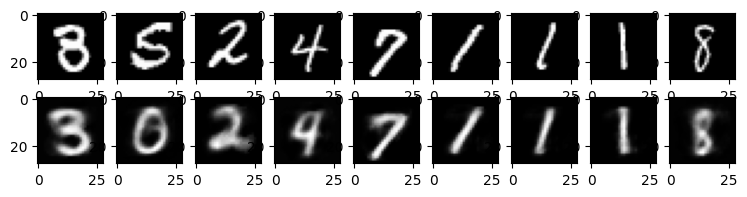

In [8]:
for k in range(0, num_epochs, 4):
    plt.figure(figsize=(9, 2))
    plt.gray()
    
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()

    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])
            
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1) # row_length + i + 1
        item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])

## **Pruebas sobre el conjunto de validación**

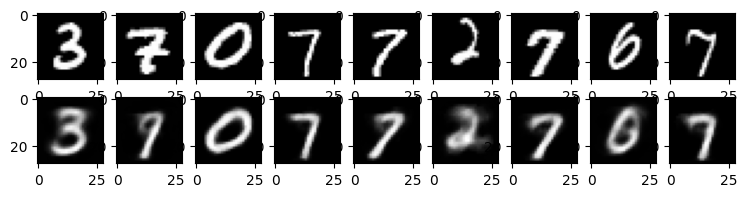

In [12]:
model.eval()

dataiter = iter(data_loader_valid)
images, labels = next(dataiter)

img = images[0]

plt.figure(figsize=(9, 2))
plt.gray()


for i, img in enumerate(images[:9]):
    with torch.no_grad():
        img2 = img.reshape(-1, 28*28) # -> use for Autoencoder_Linear
        pred = model(img2)
        recon = pred[0].detach().numpy()
        recon2 = recon.reshape(-1, 28,28) # -> use for Autoencoder_Linear

        plt.subplot(2, 9, i+1)
        plt.imshow(img[0])

        plt.subplot(2, 9, i+1+9)
        plt.imshow(recon2[0])
